## Little Case

In [ ]:
from src.linear_causality import LinearLKInformationFlow
import numpy as np
from tqdm import tqdm
# from causality_subspace import causality_subspace

dt=1
pn=1
T1=[];T2=[]
# pca = PCA(n_components=5)  # 假设我们想将数据降到2维  
Nt=100000
np.random.seed(5)
# for i in tqdm(range(100)):
X1=np.random.randn(5,Nt)*0.2
X2=np.random.randn(5,Nt)*0.2

A1=np.array([[0.9,0.6,0,0.6,0],[0,0.8,0.6,0,0.6],[0,0,0.9,0,0],[0,0,0,0.2,0],[0,0,0,0,0.2]]).T
A2=np.array([[0.2,0.6,0,0.6,0],[0,0.2,0.6,0,0.6],[0,0,0.2,0,0],[0,0,0,0.2,0],[0,0,0,0,0.2]]).T

B1=-np.array([[0,0,0,0,0],[0,0.,0,0,0],[0,0,0,0.9,0.],[0,0,0,0.,0],[0,0,0,0,0]])
B2=-np.array([[0,0,0,0,0],[0,0.0,0,0,0],[0,0,0,0,0],[0,0,0,0.4,0],[0,0,0,0,0]])
for it in range(1,Nt):
    X1[:,it]=A1@X1[:,it-1]+X1[:,it]+1*B1@X2[:,it-1] 
    X2[:,it]=A2@X2[:,it-1]+X2[:,it]+1*B2@X1[:,it-1] 
    
XX=np.zeros([10,Nt])
XX[:5]=X1
XX[5:]=X2

In [88]:
## split space intwo several subspaces, 
# e.g. [(0,1),(1,2] means the first subspace is index 0, the second subspace is index 1
# e.g. [(0,5),(5,10)] means the first subspace is index 0-4, the second subspace is index 5-9
segments = [(0, 5),(5,10)]

In [89]:
lkif = LinearLKInformationFlow(np,1)
lkif.causality_estimate(XX[:,-15000:].T, lag_list=[1], segments=segments)

In [90]:
result_dict = lkif.get_dict()

In [93]:
## significance test
np.abs(result_dict["information_flow"]) > result_dict["statistics"]["p99_critical_value"]

array([[ True, False],
       [ True,  True]])

---
---

## Prof. Liang's case
+ There is no information flow between X and Y in fact.
+ The original significance test, using a 90% confidence interval, will show a limited information flow.
+ The modified method, on the other hand, will correctly accept the null hypothesis ($H_0$).

In [95]:
## load data/X.dat and Y.dat
import pandas as pd
data_X = pd.read_csv('data/X.dat', header=None)
data_Y = pd.read_csv('data/Y.dat', header=None)

In [96]:
data_X = data_X.to_numpy()
data_Y = data_Y.to_numpy()

In [97]:
data = np.concatenate((data_X, data_Y), axis=1)

In [98]:
segments = [(0,1),(1,2)]

In [99]:
lkif = LinearLKInformationFlow(np,1)
lkif.causality_estimate(data, lag_list=[1], segments=segments)

In [100]:
result_dict = lkif.get_dict()

In [101]:
print('## 是否存在因果关系 (False 代表无信息流)\n')
print("### 使用原本的方差检验方法")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std_origin"] * 1.65)
print("```")

print("### 使用新的方差检验方法")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std"] * 1.65)
print("```")


## 是否存在因果关系 (False 代表无信息流)

### 使用原本的方差检验方法
```
[[ True False]
 [ True  True]]
```
### 使用新的方差检验方法
```
[[ True False]
 [False  True]]
```


---
---
## Bootstrap Method V.S. Significance test Method

In [11]:
import numpy as np
from tqdm import tqdm

noise_strength = 1
np.random.seed(27)

# 调整参数
dt = 1 # 时间步长
Nt = 100000  # 时间步数
d = 6  # 维度
# 构建系统矩阵 A
# A = np.array([[-0.4,  0.4, -0.6,  0.4,  0.2, -0.2],
#        [-0.1, -0.2,  0.4,  0.1, -0.4, -0. ],
#        [ 0.7, -0.5, -0.1, -0.2, -0. ,  0.1],
#        [-0.3, -0.1,  0.2, -0.1,  0.2, -0.3],
#        [-0.2,  0.4,  0.1, -0.2, -0.1, -0.3],
#        [ 0. ,  0.2,  0. ,  0.4,  0.3, -0.2]])
A = np.array([[-0.1, 0., 0., -0.1, 0., -0.3],
              [0.6, -0.2, 0., -0., -0.4, 0.5],
              [0., 0.6, -0.8, 0.1, -0., -0.],
              [-0., 0.1, -0., -0.8, 0., 0.],
              [-0., 0.3, -0.1, 0.6, -0.7, 0.],
              [-0.2, -0., -0.1, 0., 0.6, -0.5]])

# 确定噪声矩阵 B
B = np.random.randn(d, d) * noise_strength# 适当缩小噪声规模
f = np.array([0.1,-0.1,0.1,-0.2,0.2,0.1])
# 初始化状态变量
X = np.zeros((d, Nt))
X[:, 0] = np.random.randn(d)  # 初始状态

# 生成数据
for t in tqdm(range(1, Nt)):
    X[:, t] = X[:, t-1] + dt * (A @ X[:, t-1] +f) + B @ np.random.randn(d) * np.sqrt(dt)

100%|██████████| 99999/99999 [00:02<00:00, 45066.66it/s]


In [12]:
from src.linear_causality import LinearLKInformationFlow
import numpy as np
import matplotlib.pyplot as plt

In [17]:
## 去掉对角元素
def remove_diagonal(matrix):
    mask = ~np.eye(matrix.shape[0], dtype=bool)
    return matrix[mask].flatten()

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


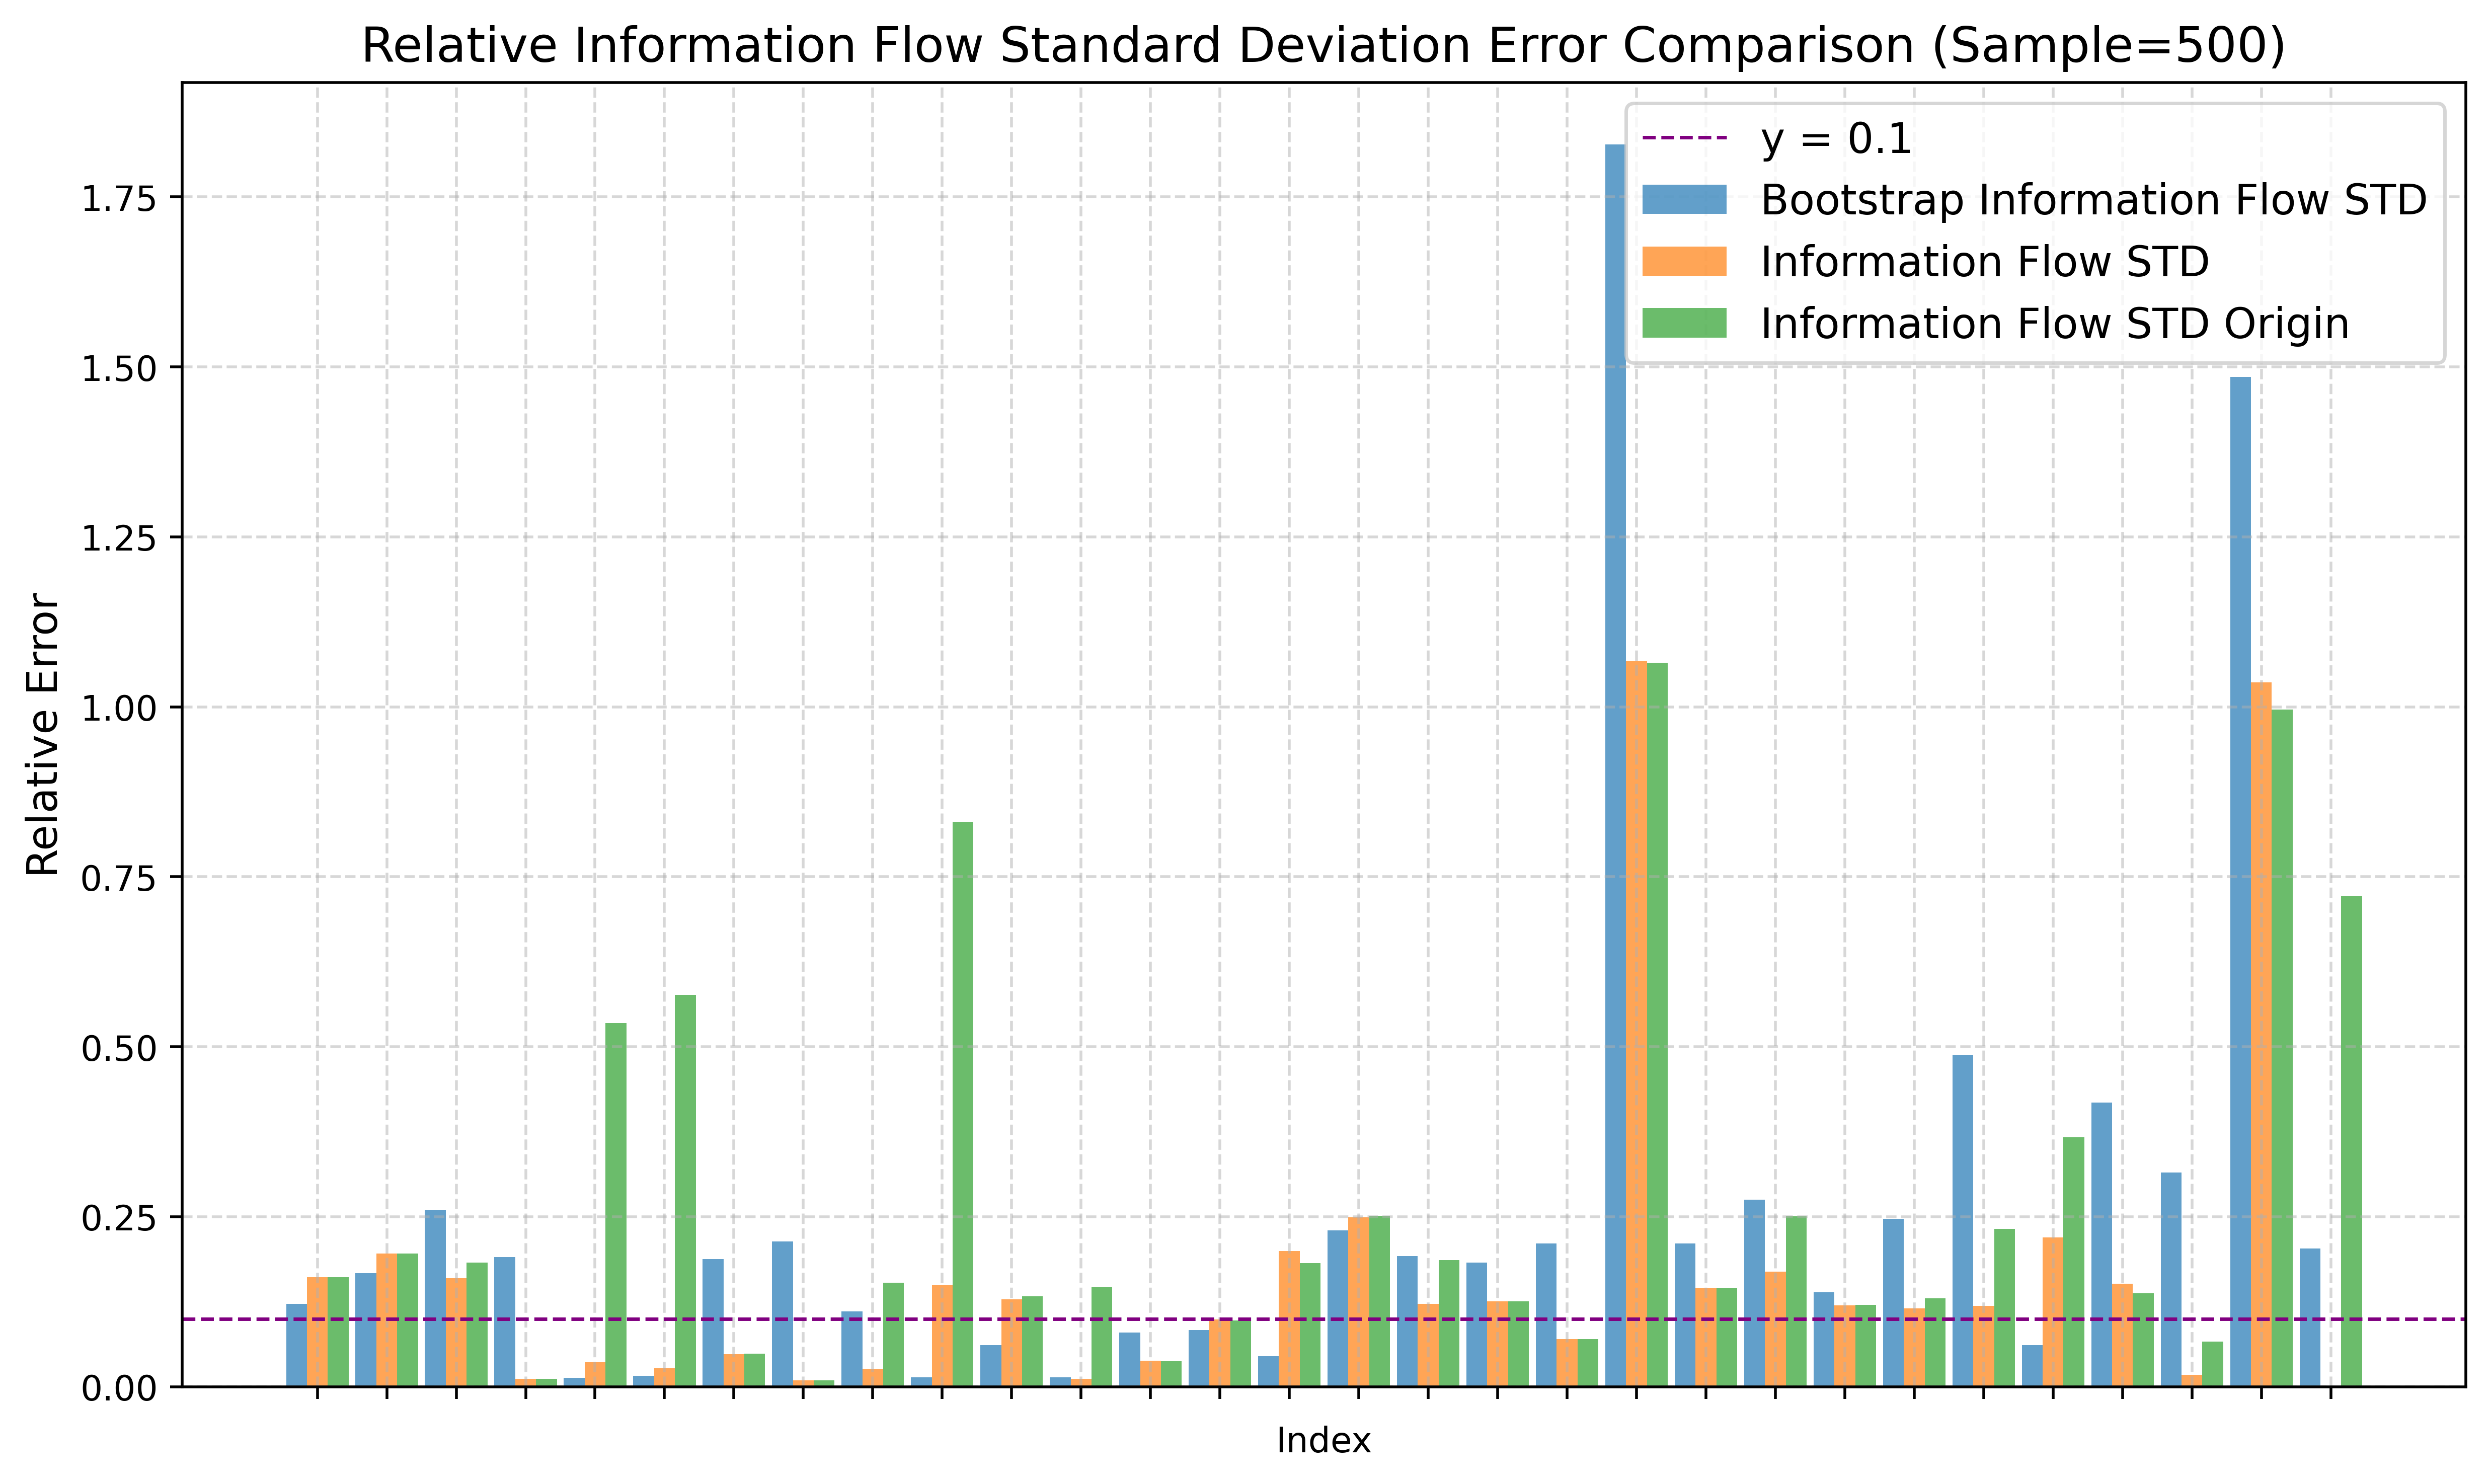

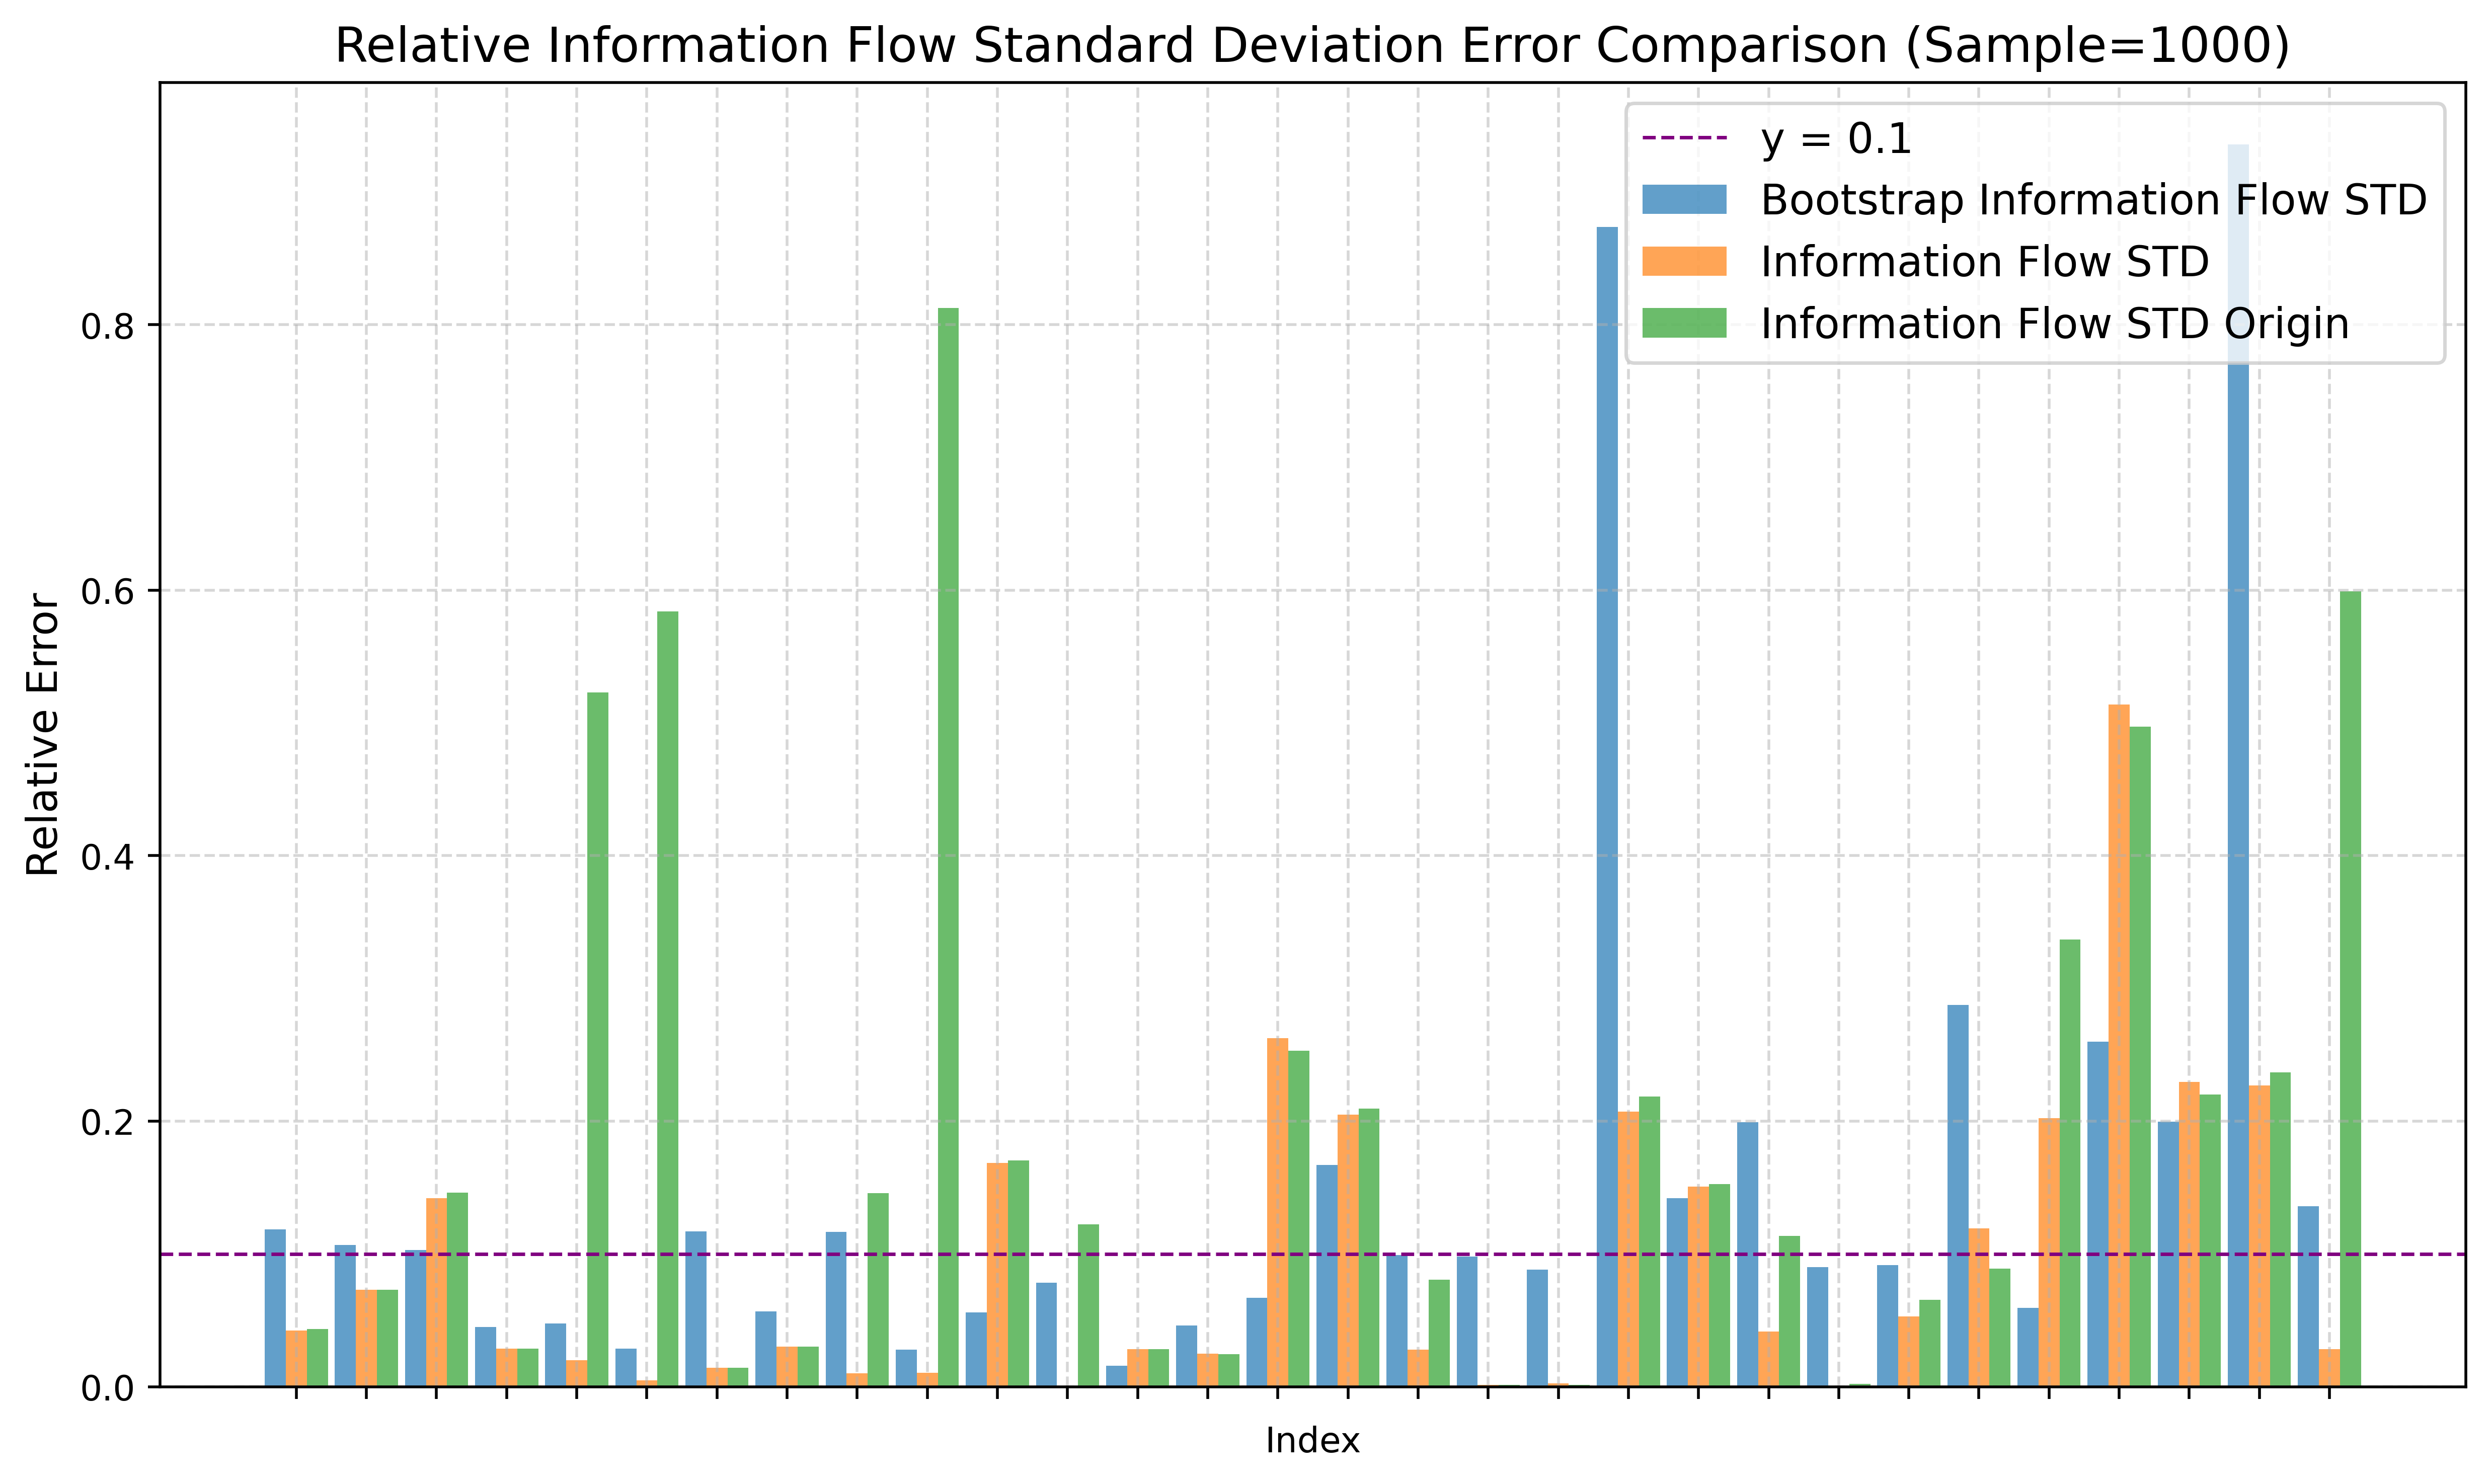

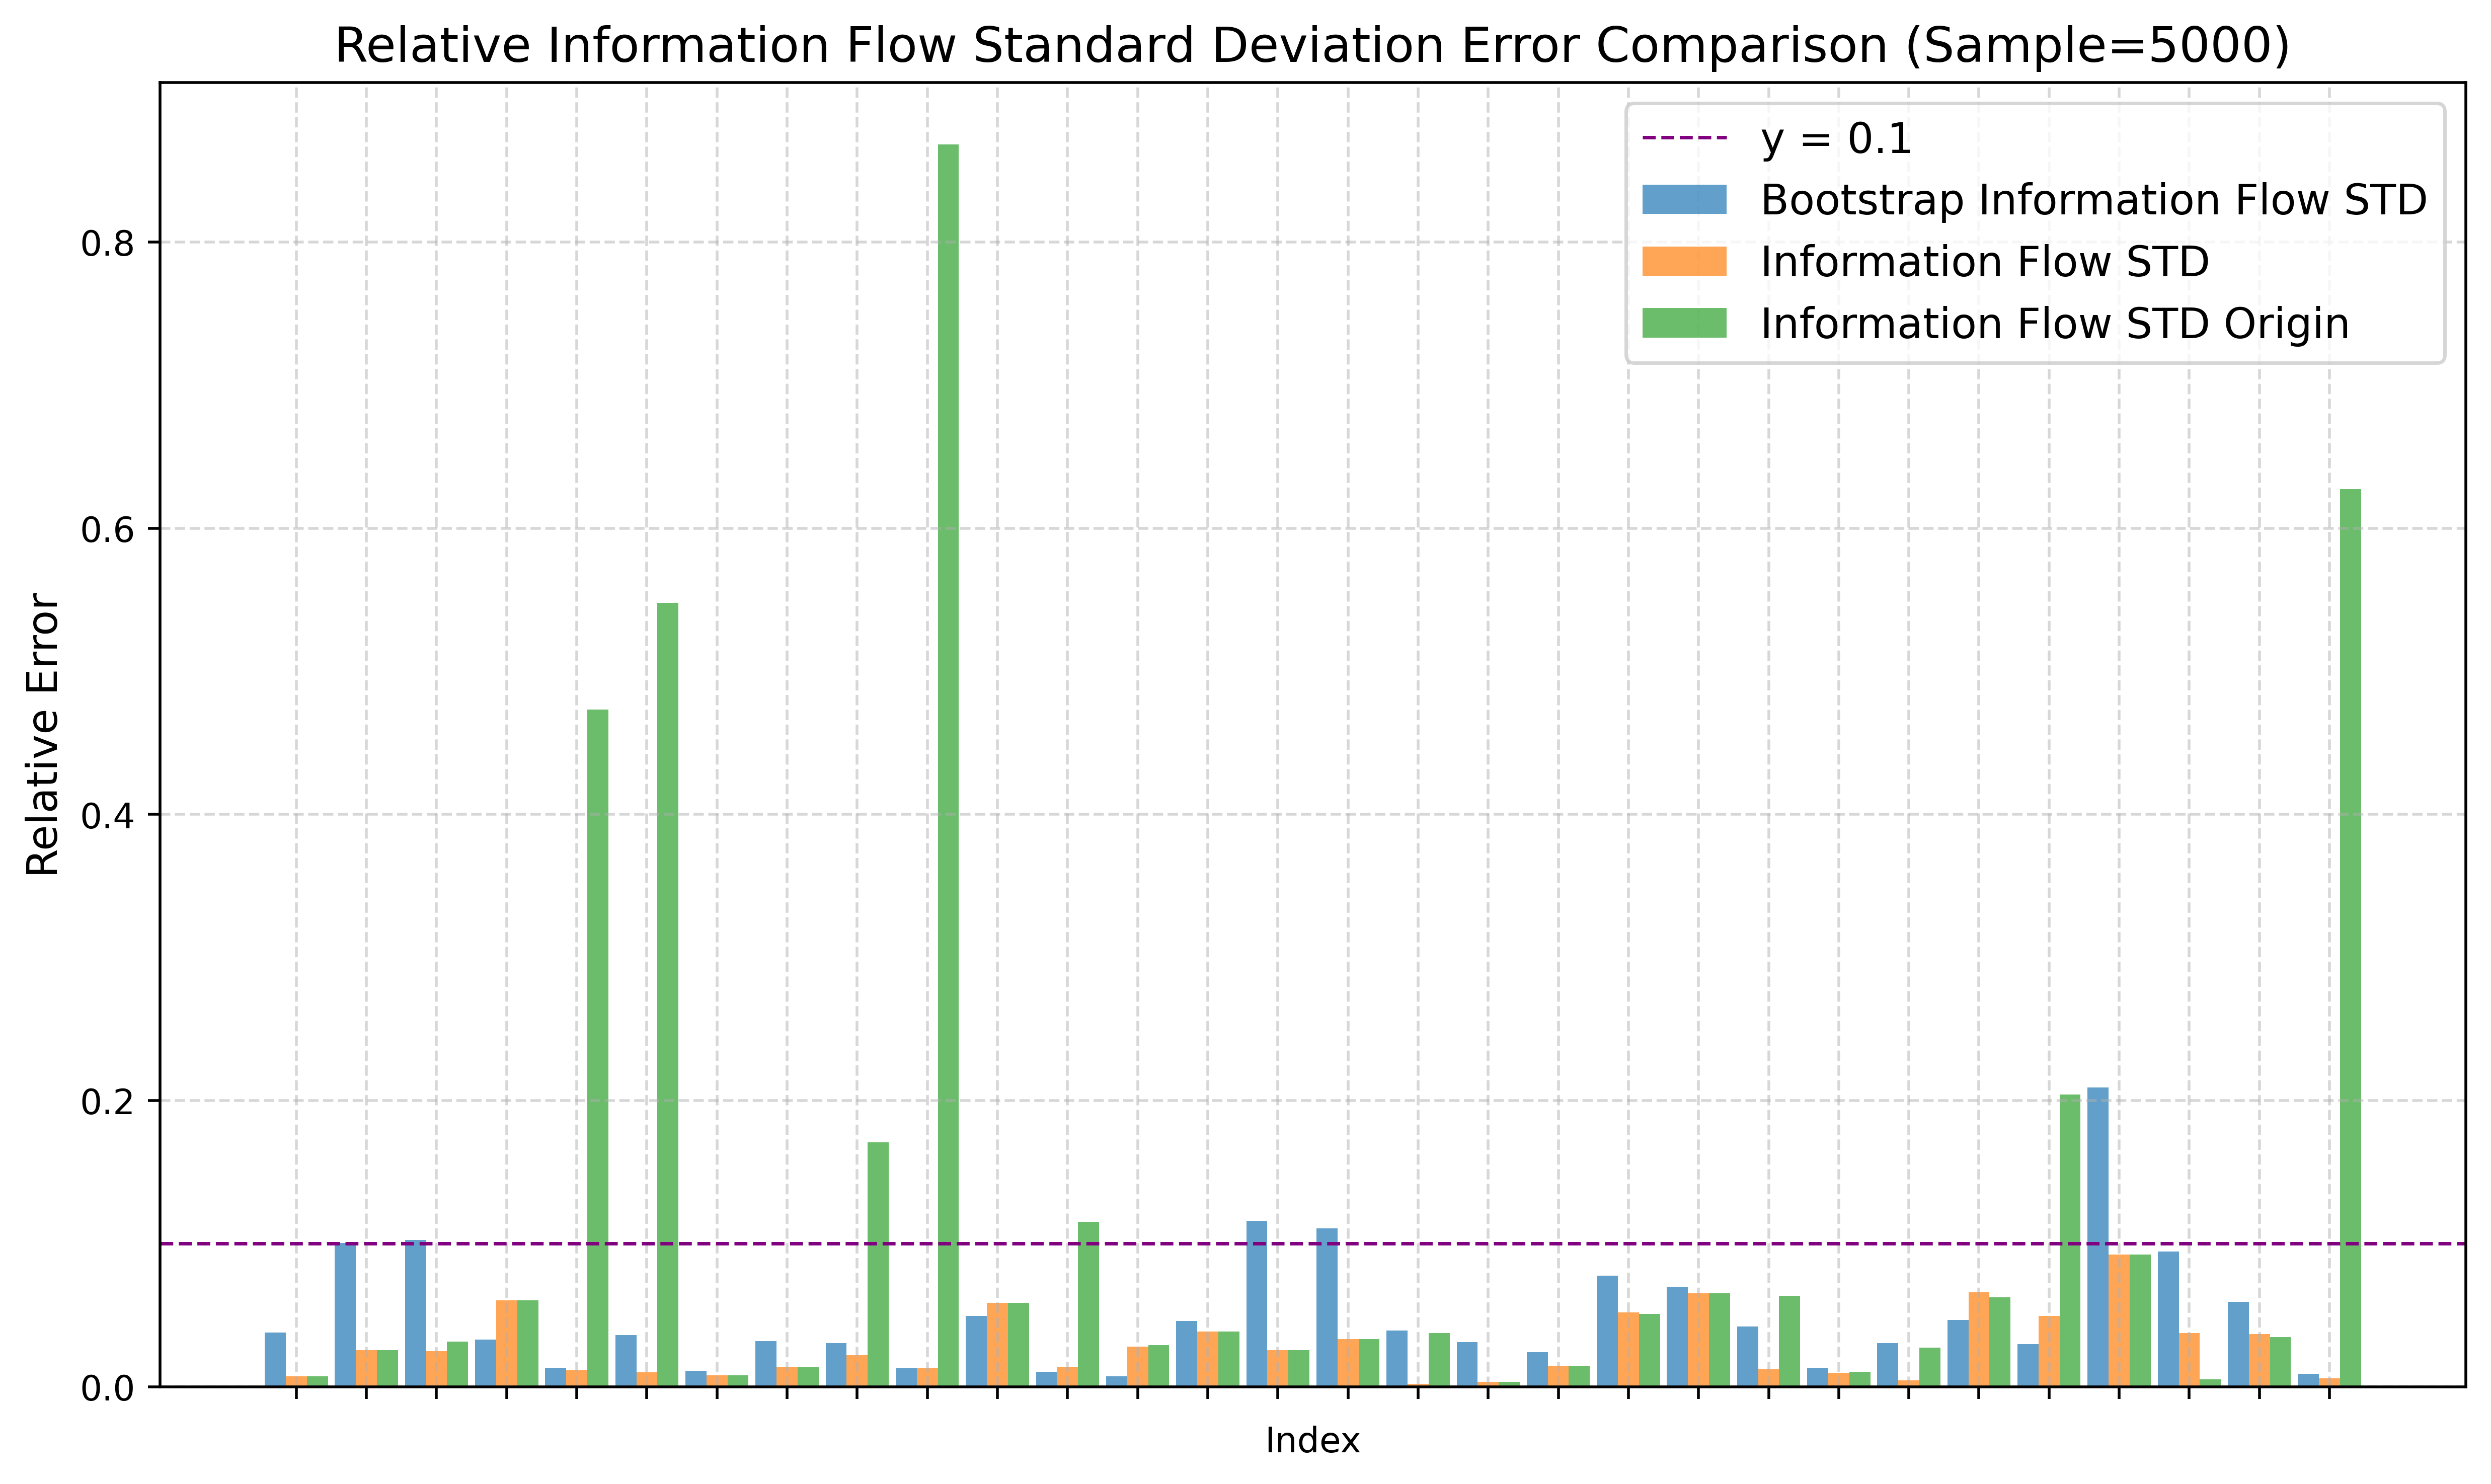

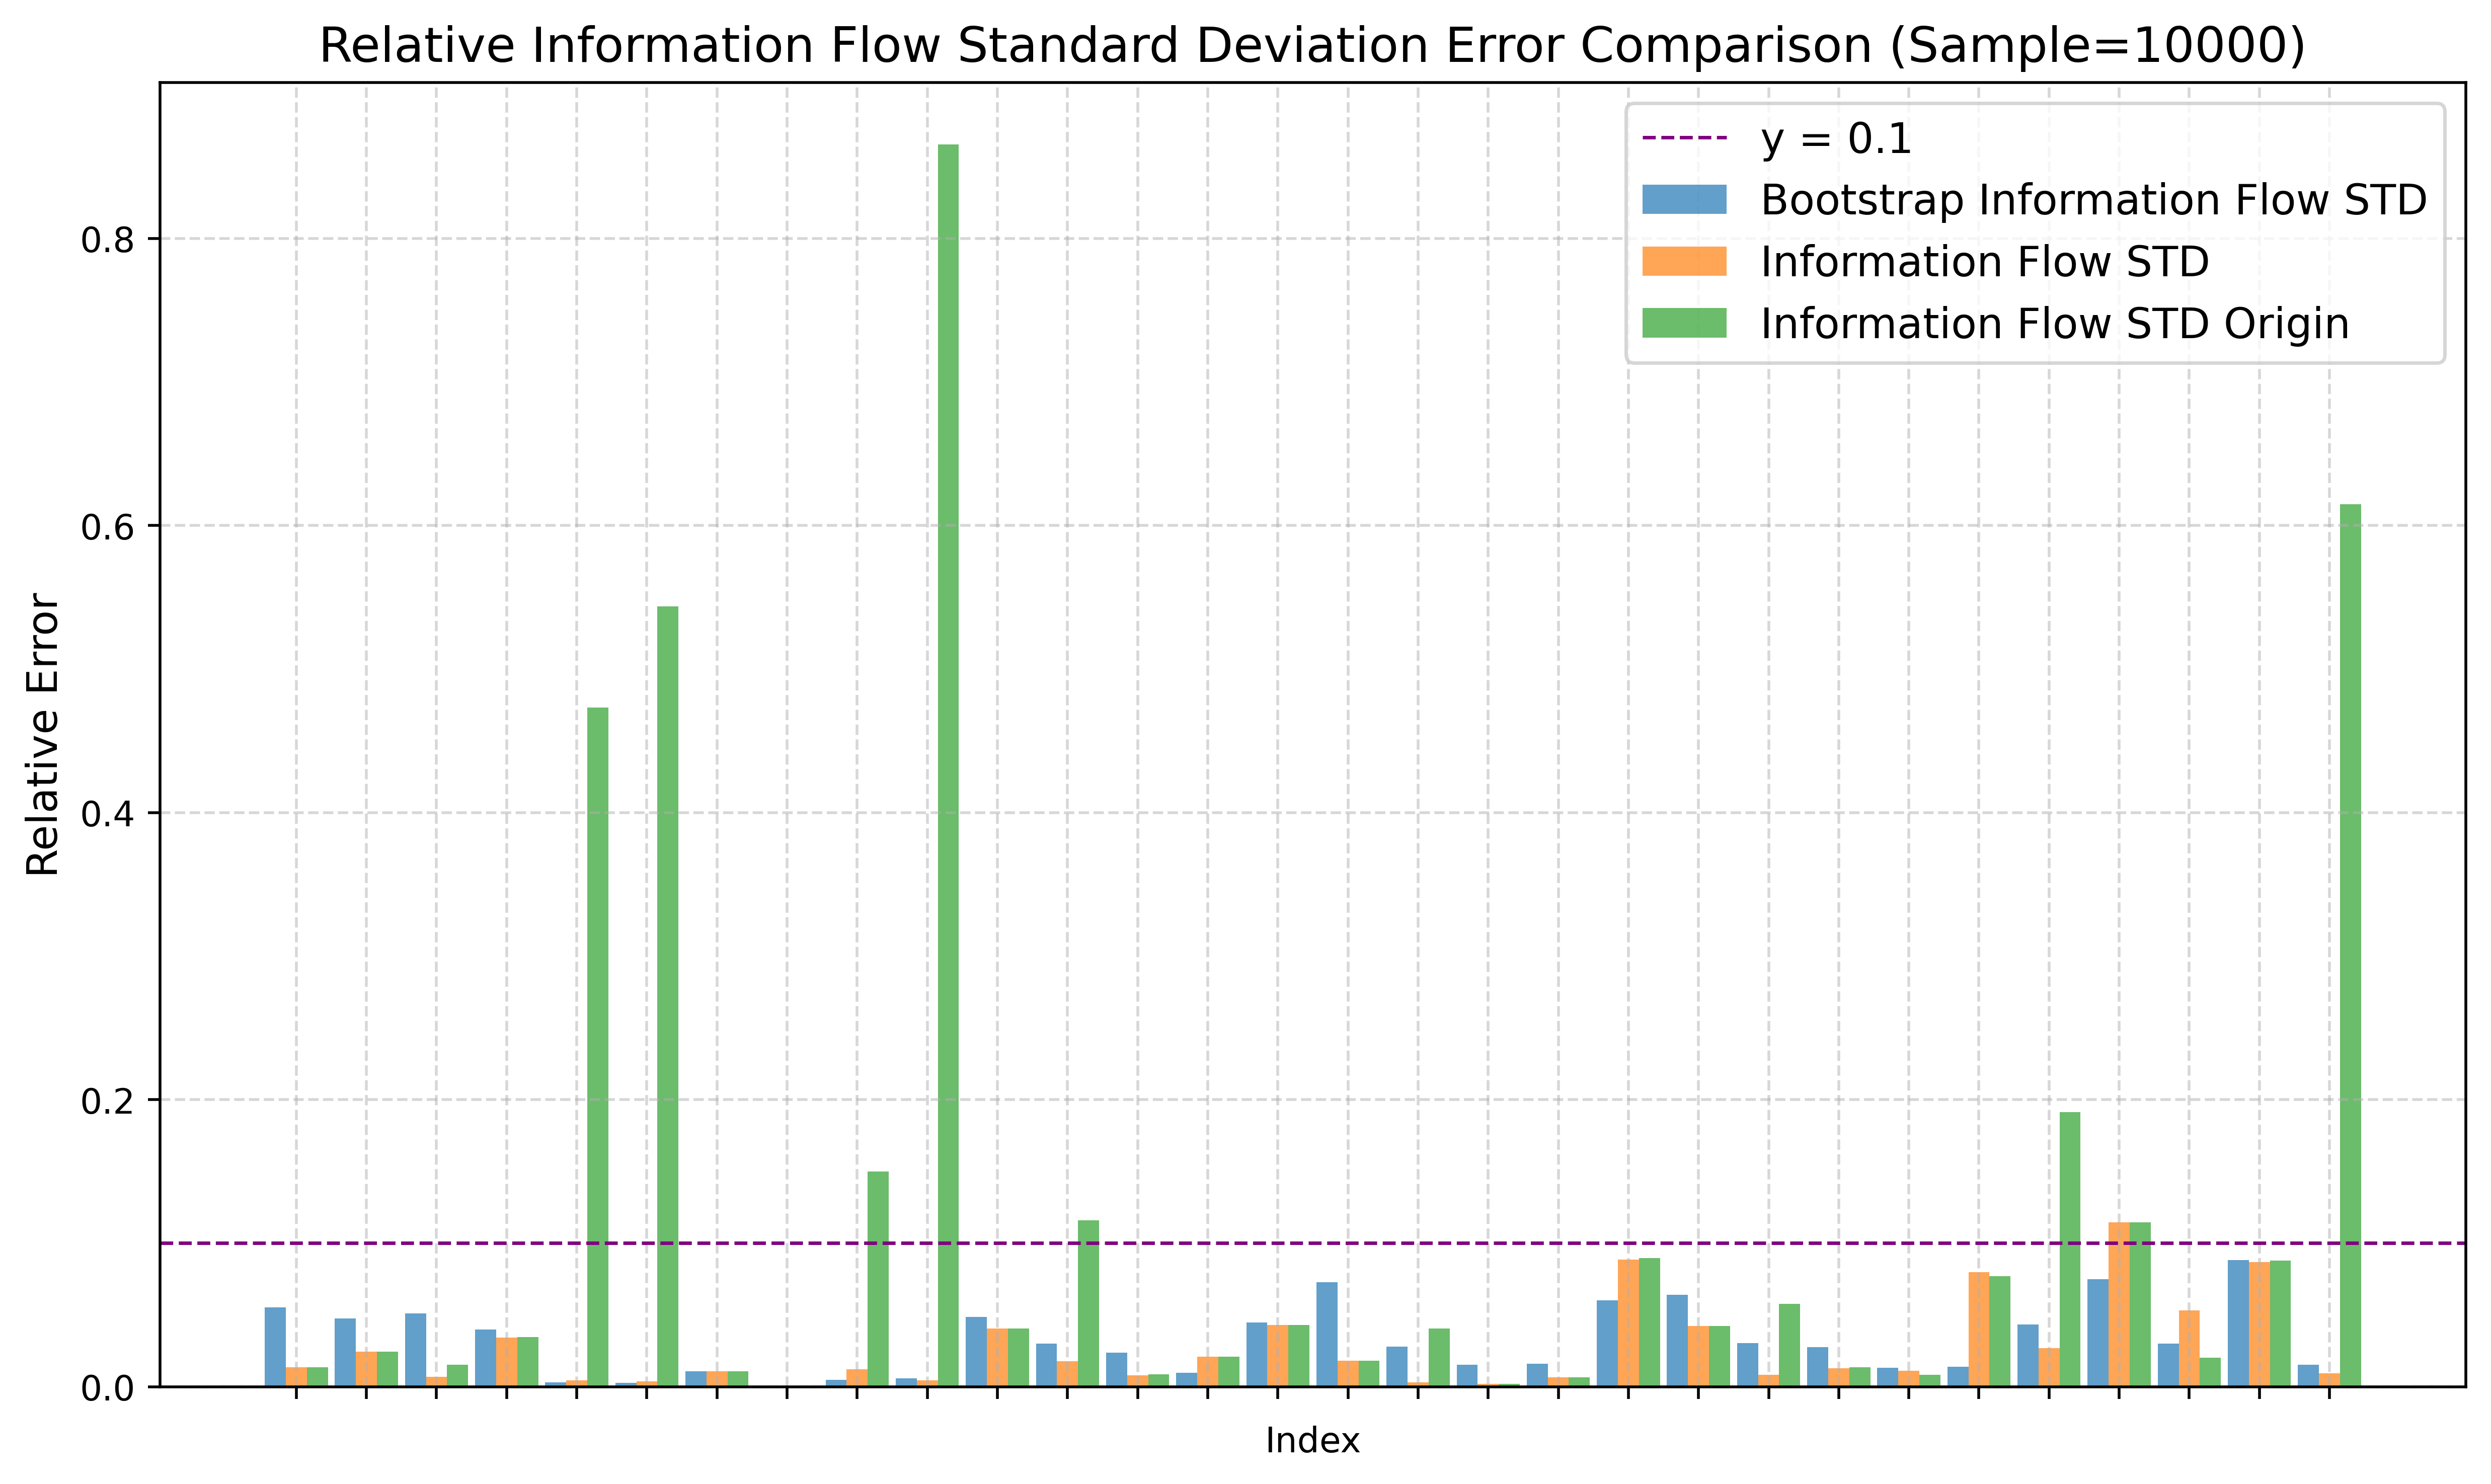

In [20]:
lkif = LinearLKInformationFlow(np, dt)
for sample_num in [500,1000,5000,10000]:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    # segments = [(0,3),(3,6)]
    lkif.causality_estimate(X[:,:sample_num].T, lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif.get_dict()
    bootstrap_result = lkif.bootstrap_estimate(X[:,-sample_num:].T, lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif.real_information_flow_linear_case(A,B)

    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

    x = np.arange(len(y1))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    ax.bar(x - width, y1, width, label='Bootstrap Information Flow STD', alpha=0.7)
    ax.bar(x, y2, width, label='Information Flow STD ', alpha=0.7)
    ax.bar(x + width, y3, width, label='Information Flow STD Origin', alpha=0.7)

    # 设置标题和标签
    ax.set_title(f'Relative Information Flow Standard Deviation Error Comparison (Sample={sample_num})', fontsize=14)
    ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([])  # 隐藏 x 轴刻度标签
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label='y = 0.1')
    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=12)

    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/2_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')


In [21]:
import numpy as np
from tqdm import tqdm

noise_strength = 1
np.random.seed(29)

# 调整参数
dt = 0.1 # 时间步长
Nt = 500000  # 时间步数
d = 6  # 维度
# 构建系统矩阵 A
A = np.array([[-0.4,  0.4, -0.6,  0.4,  0.2, -0.2],
       [-0.1, -0.2,  0.4,  0.1, -0.4, -0. ],
       [ 0.7, -0.5, -0.1, -0.2, -0. ,  0.1],
       [-0.3, -0.1,  0.2, -0.1,  0.2, -0.3],
       [-0.2,  0.4,  0.1, -0.2, -0.1, -0.3],
       [ 0. ,  0.2,  0. ,  0.4,  0.3, -0.2]])
# A = np.array([[-0.1, 0., 0., -0.1, 0., -0.3],
#               [0.6, -0.2, 0., -0., -0.4, 0.5],
#               [0., 0.6, -0.8, 0.1, -0., -0.],
#               [-0., 0.1, -0., -0.8, 0., 0.],
#               [-0., 0.3, -0.1, 0.6, -0.7, 0.],
#               [-0., -0., -0.1, 0., 0.6, -0.5]])

# 确定噪声矩阵 B
B = np.random.randn(d, d) * noise_strength# 适当缩小噪声规模
f = np.array([0.,-0.,0.,-0.,0.,0.])
# 初始化状态变量
X = np.zeros((d, Nt))
X[:, 0] = np.random.randn(d)  # 初始状态

# 生成数据
for t in tqdm(range(1, Nt)):
    X[:, t] = X[:, t-1] + dt * (A @ X[:, t-1] +f) + B @ np.random.randn(d) * np.sqrt(dt)

100%|██████████| 499999/499999 [00:09<00:00, 51001.77it/s]


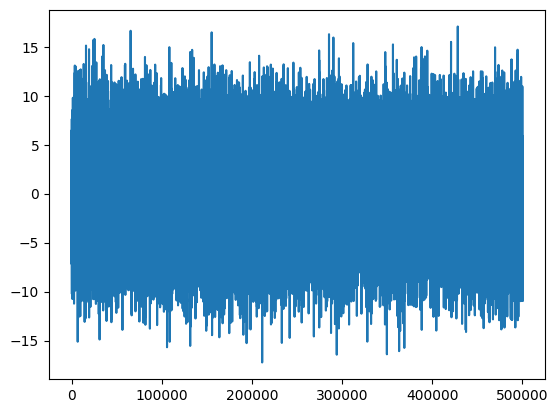

In [22]:
plt.plot(X[0])

In [23]:
from src.linear_causality import LinearLKInformationFlow
import numpy as np
import matplotlib.pyplot as plt

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


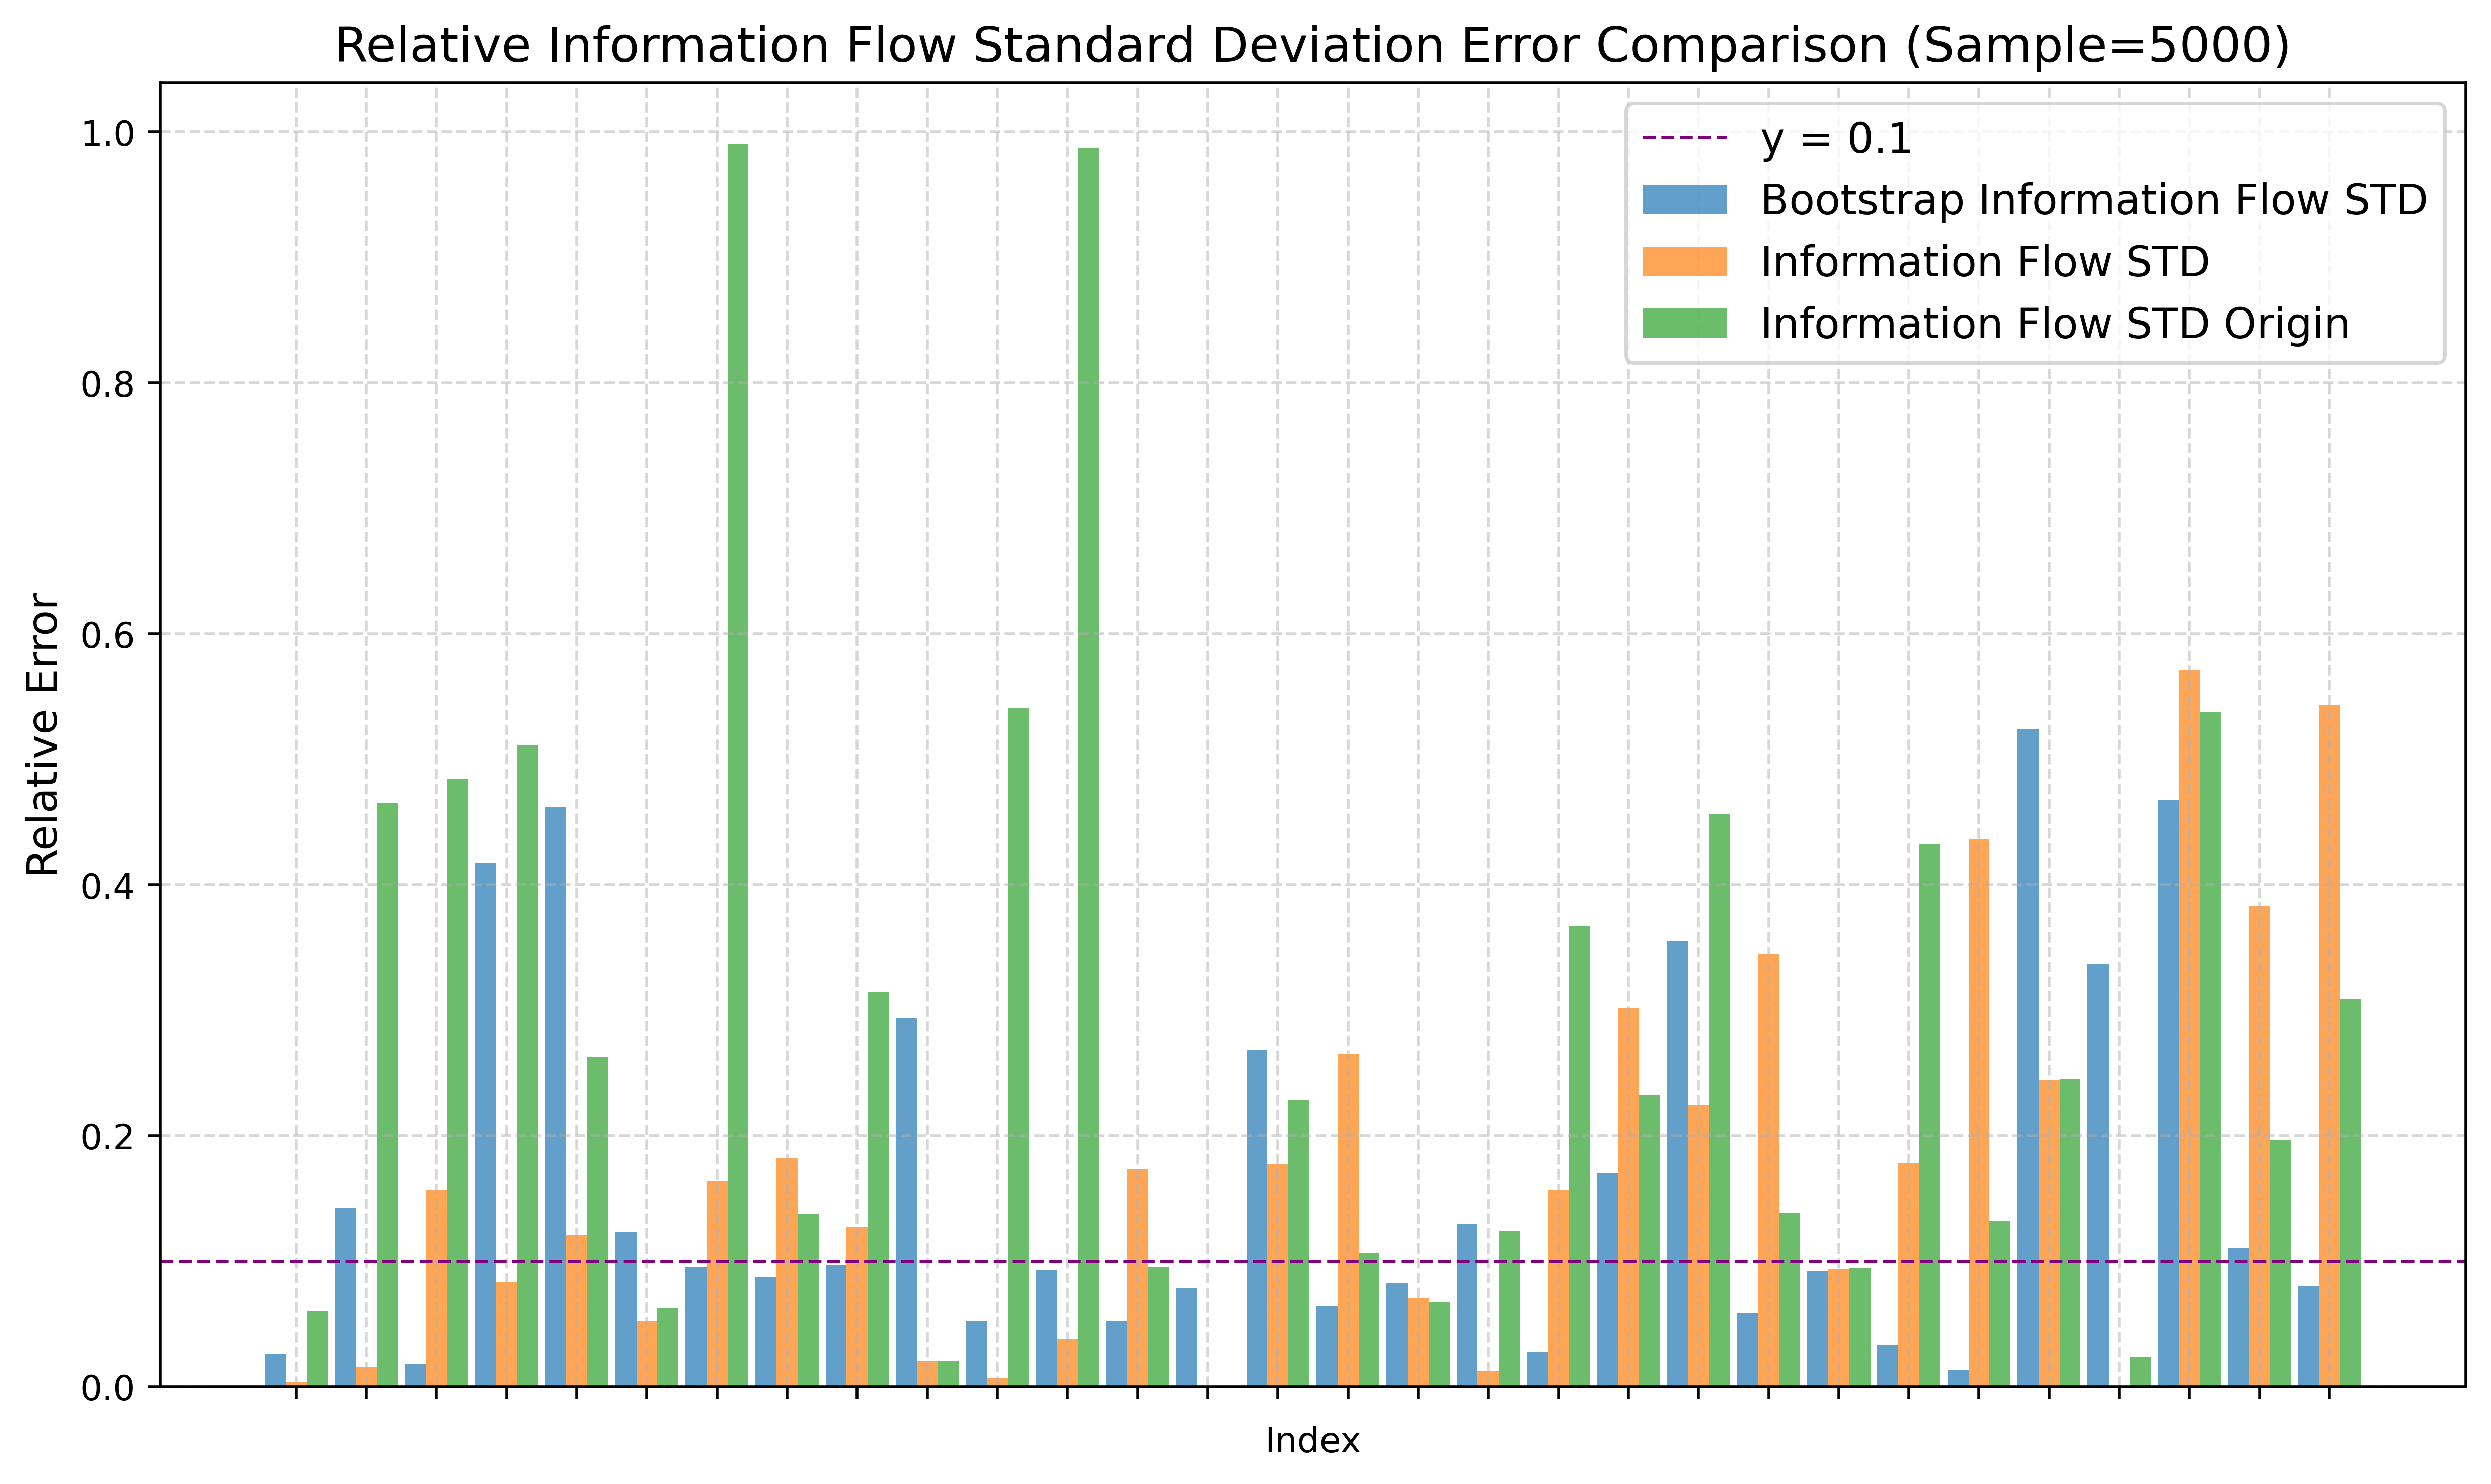

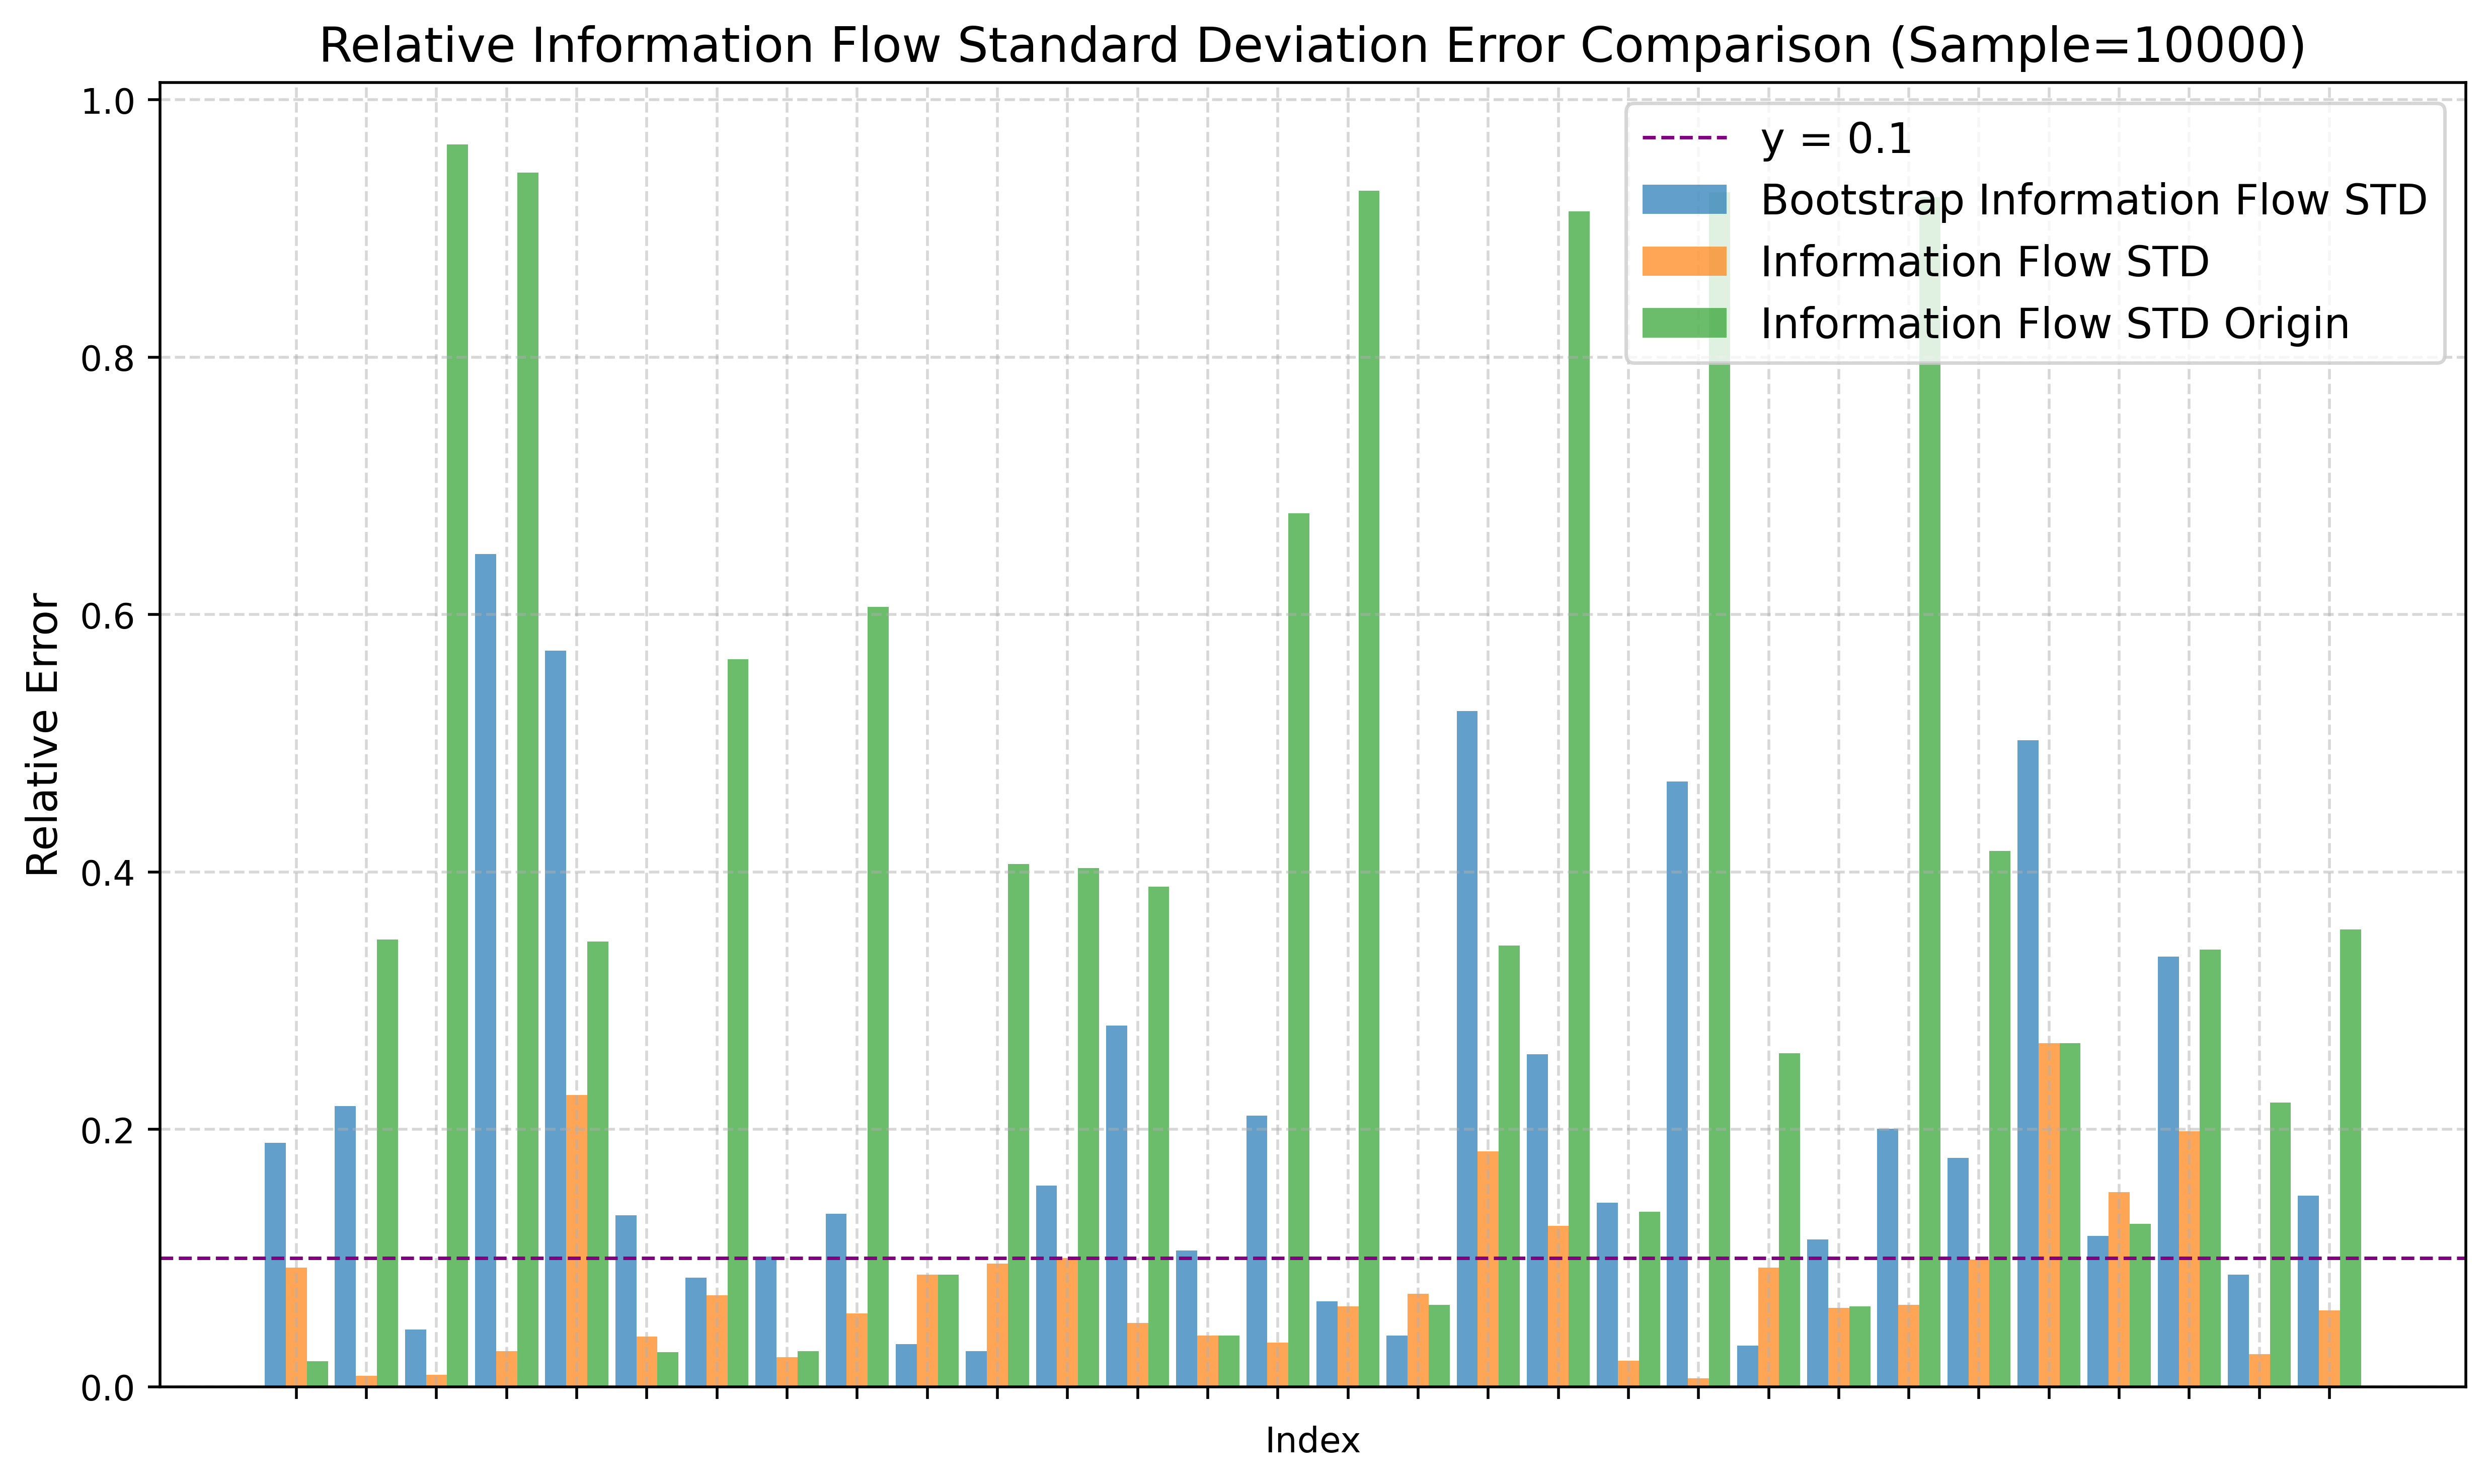

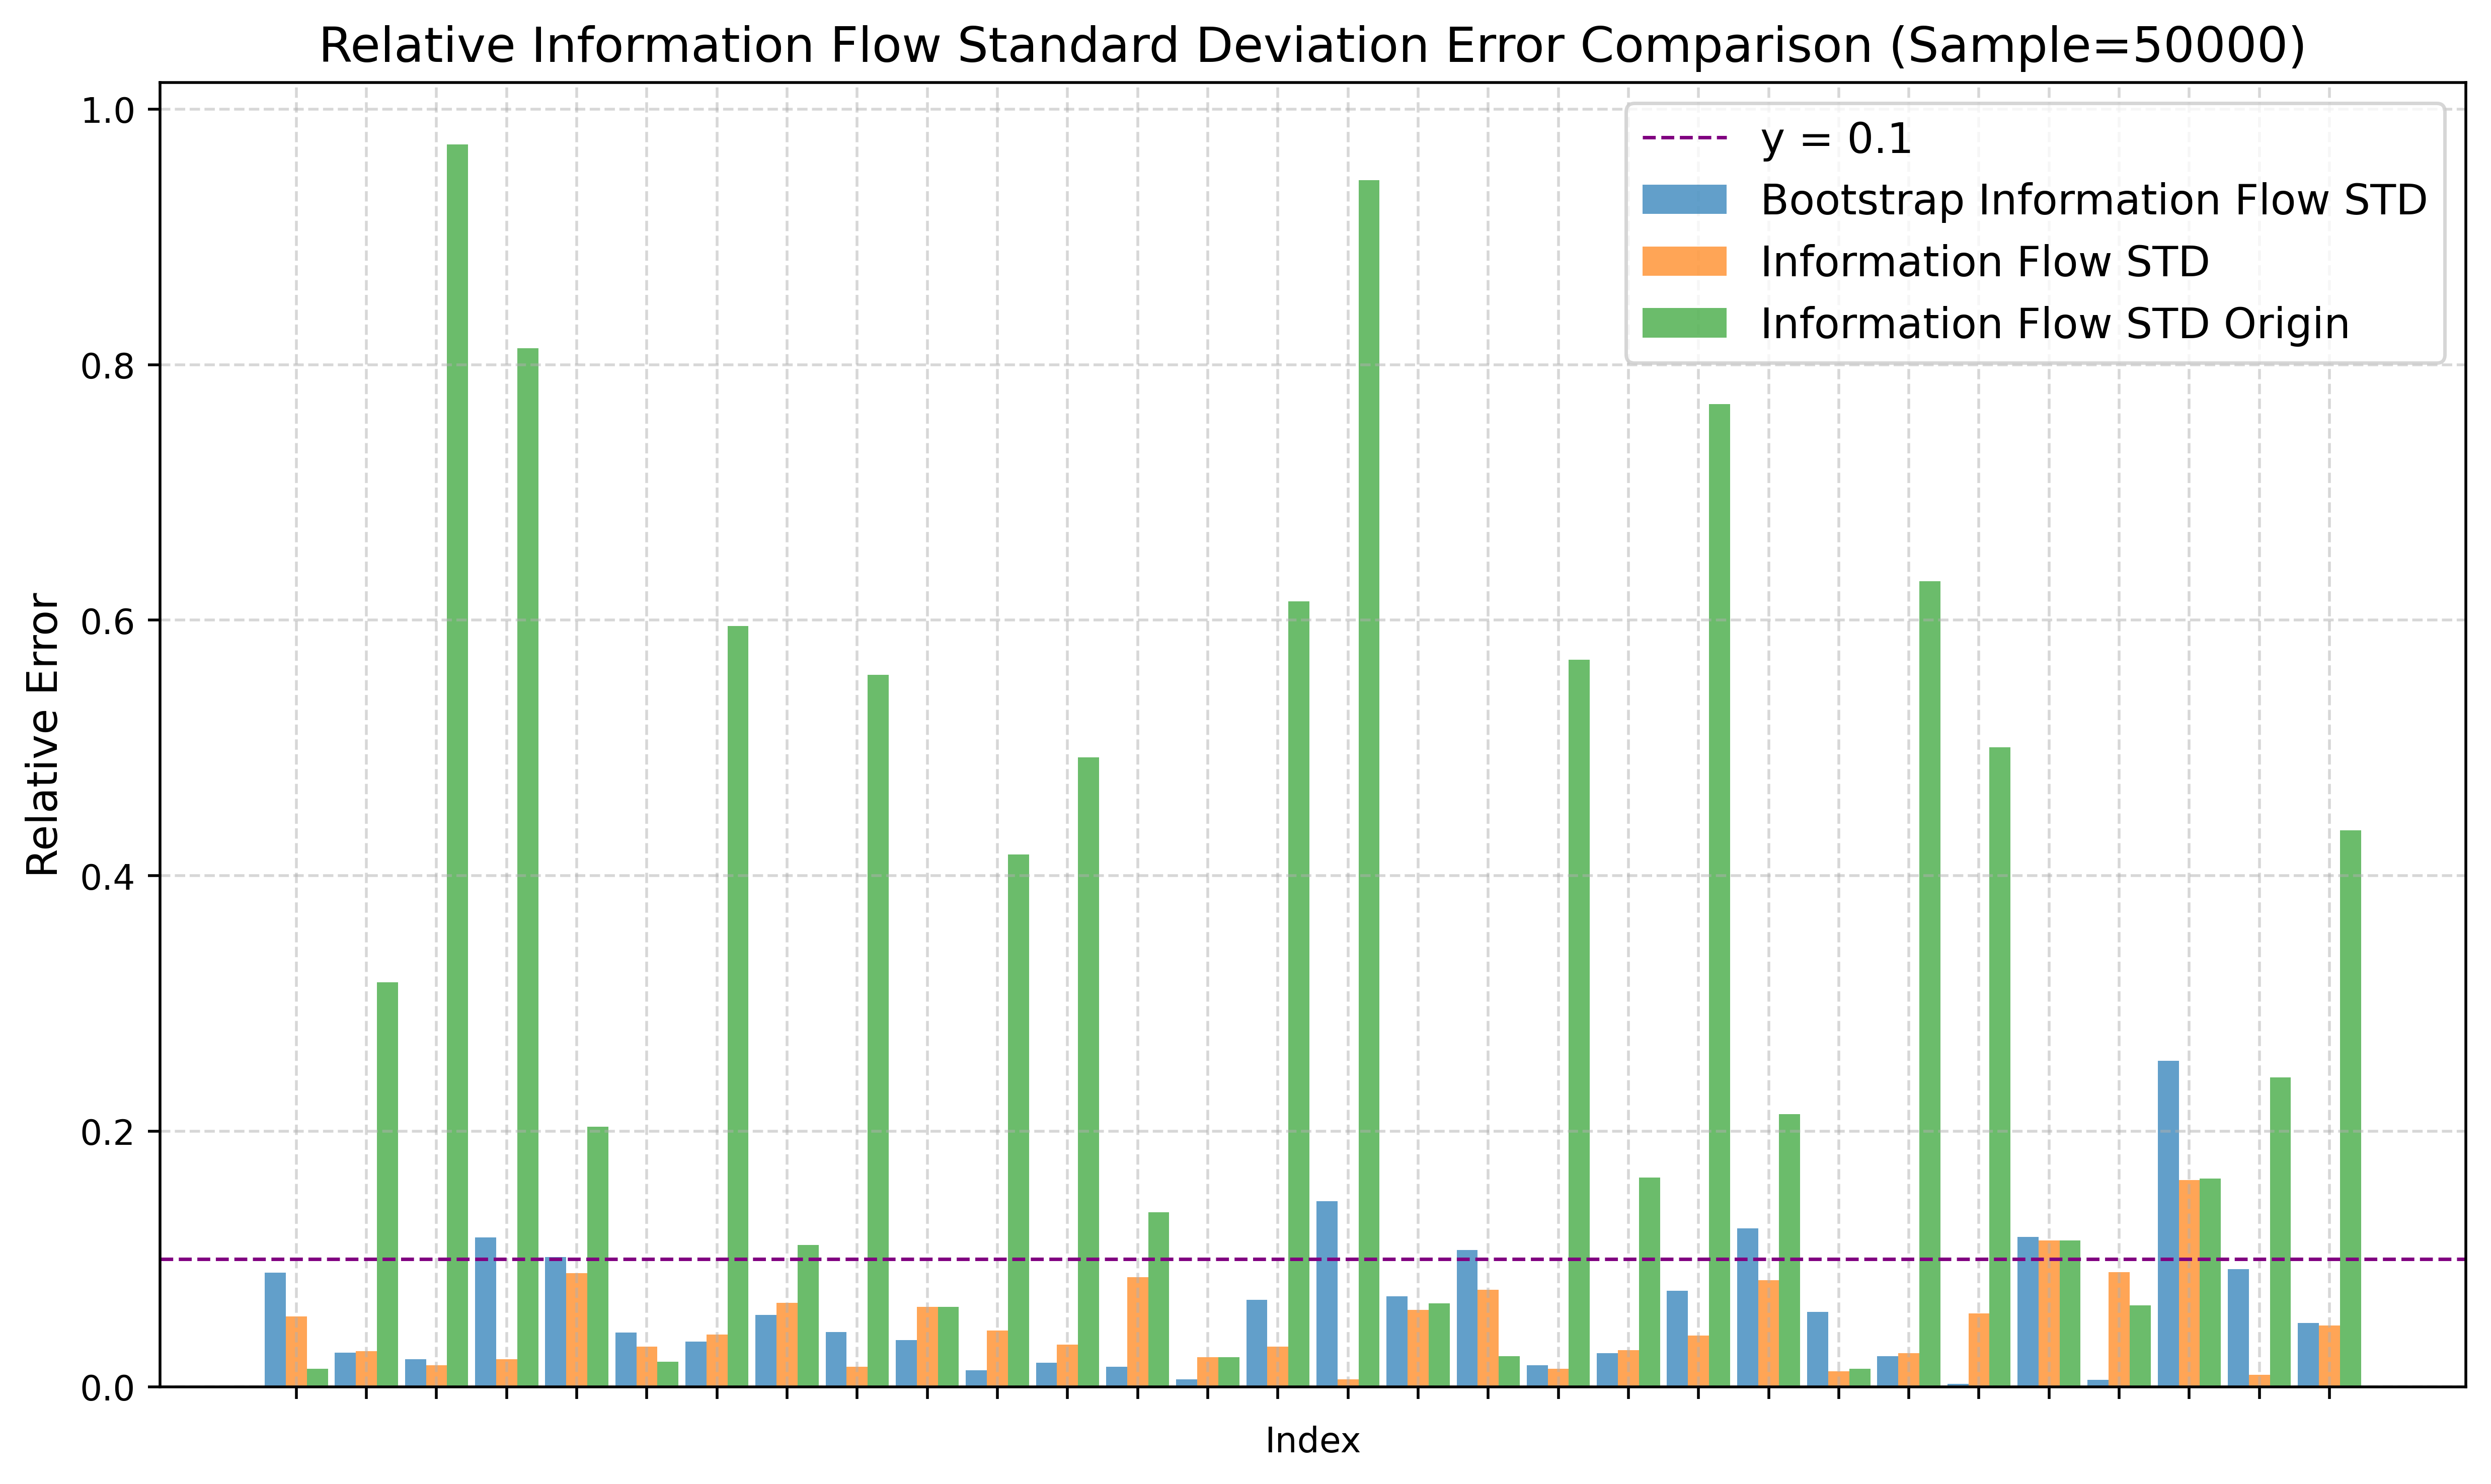

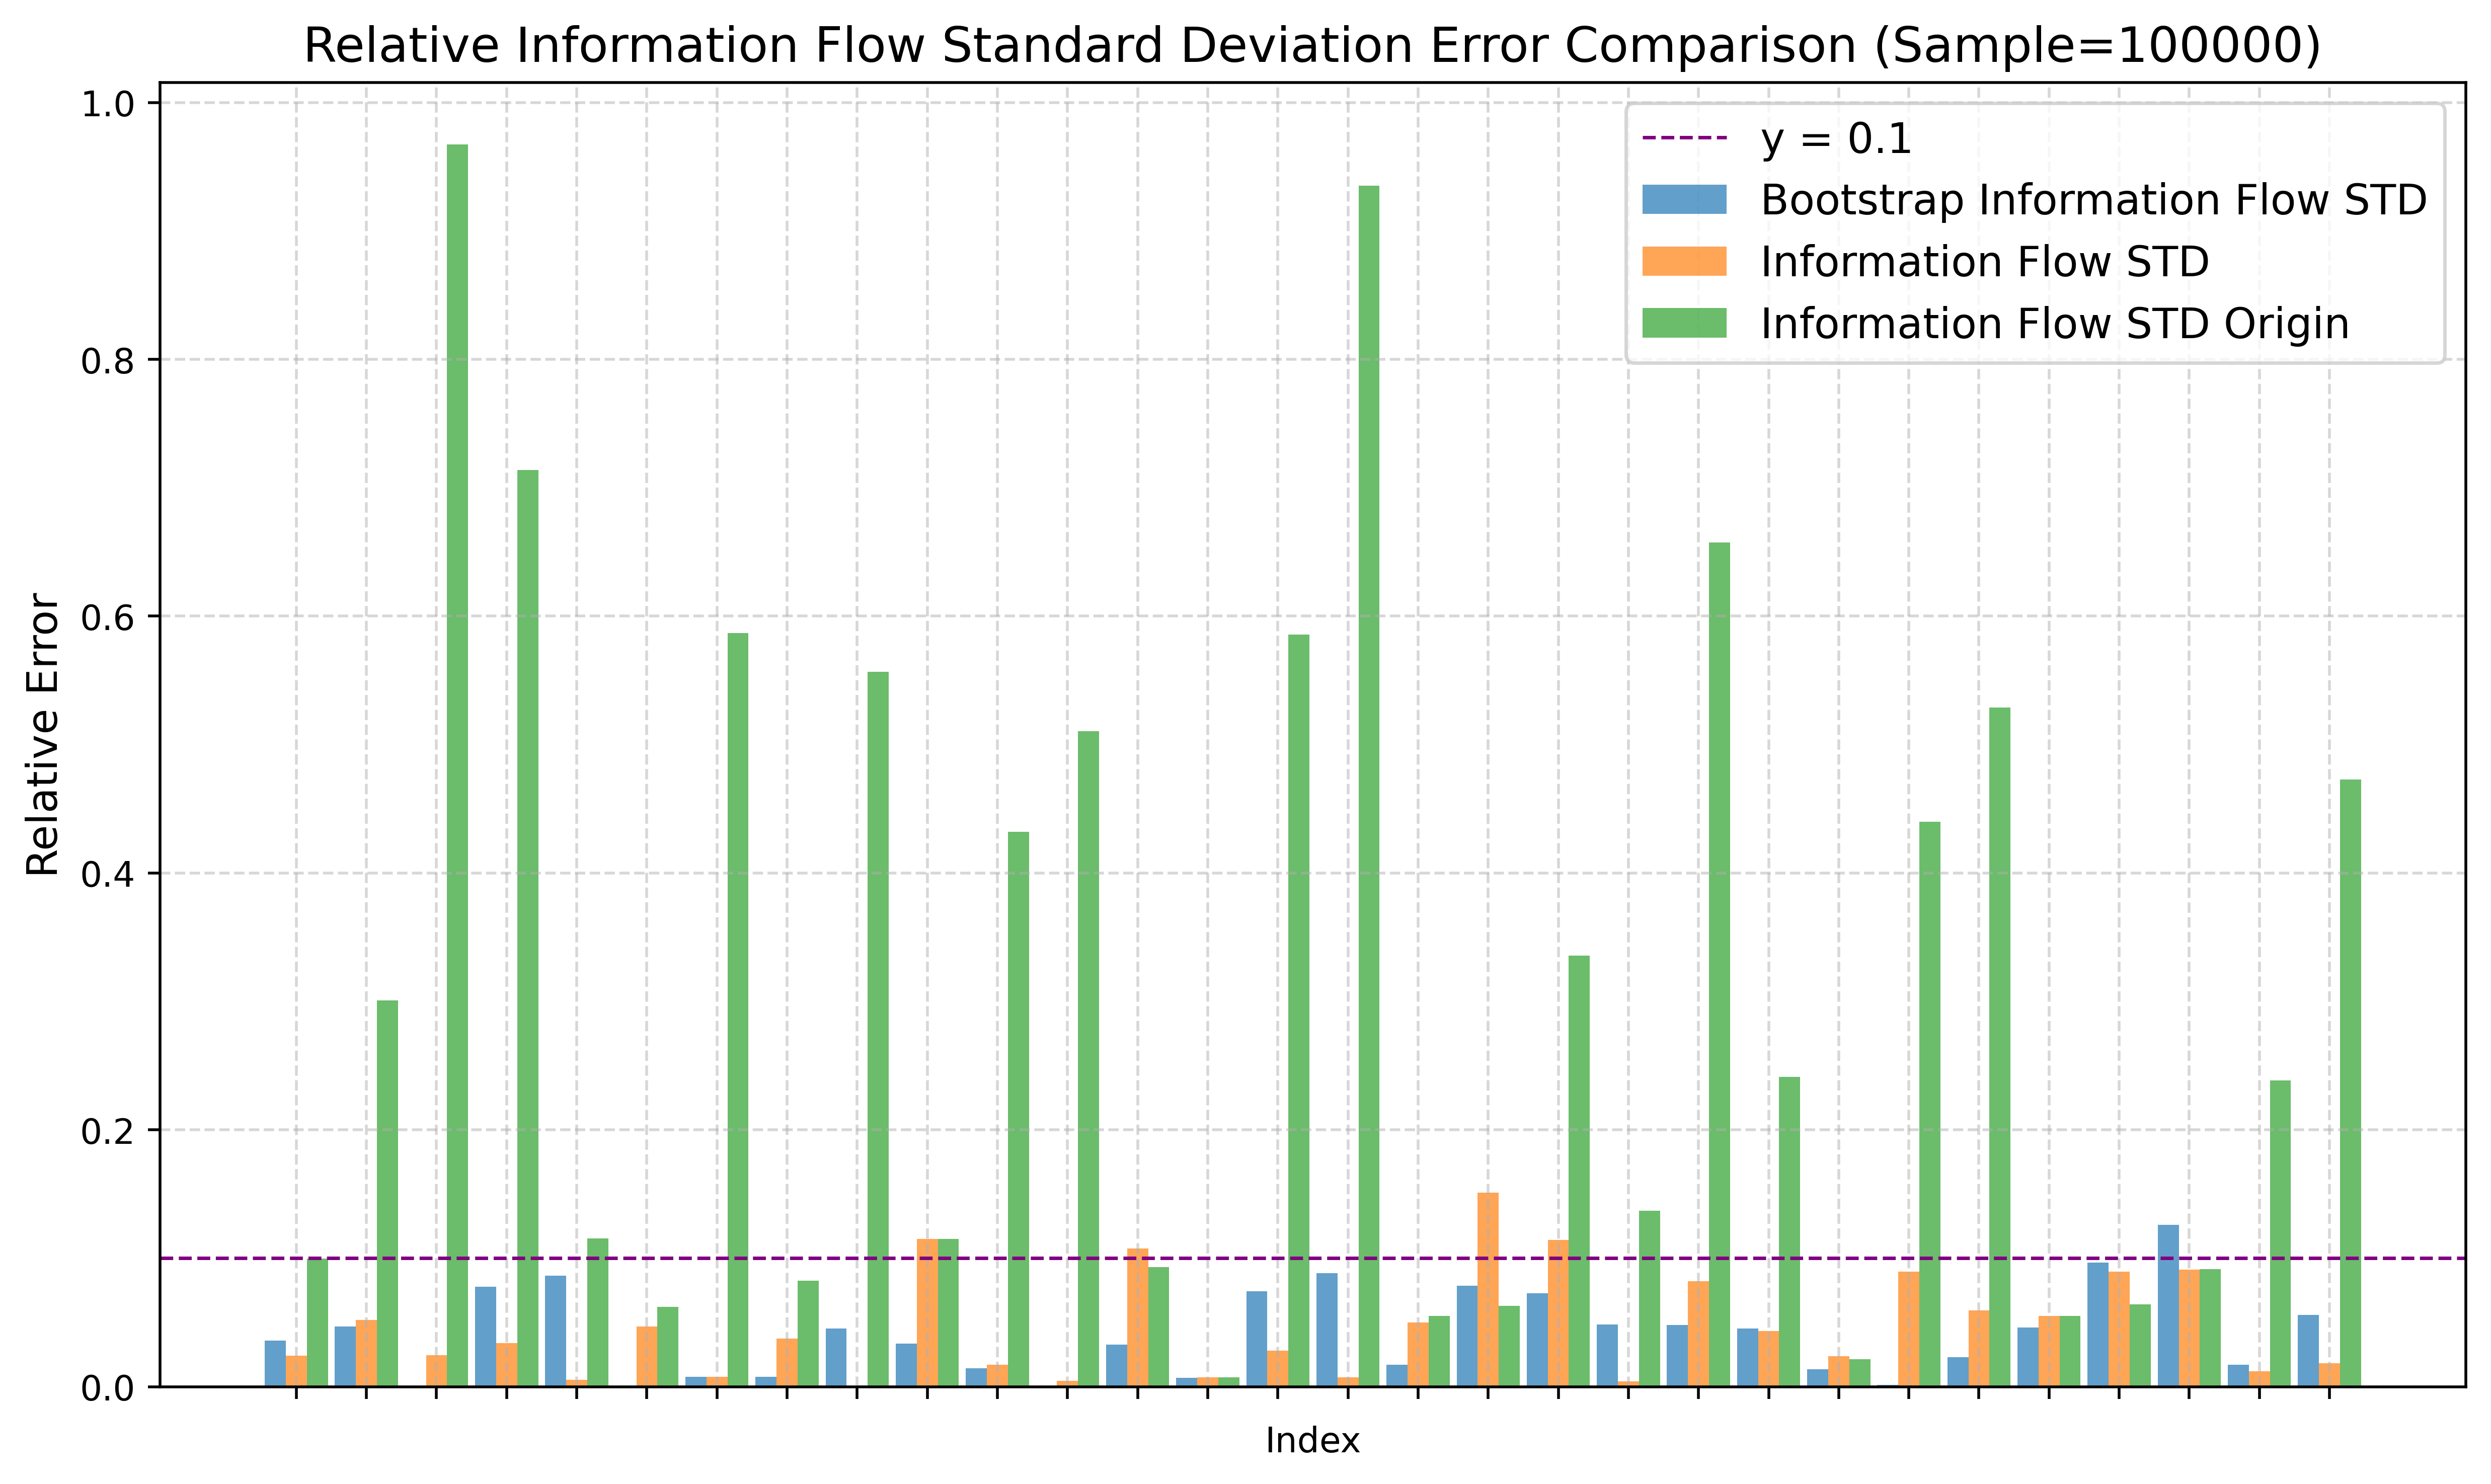

In [24]:
lkif = LinearLKInformationFlow(np, dt)
for sample_num in [5000,10000,50000,100000]:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    # segments = [(0,3),(3,6)]
    lkif.causality_estimate(X[:,:sample_num].T, lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif.get_dict()
    bootstrap_result = lkif.bootstrap_estimate(X[:,-sample_num:].T, lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif.real_information_flow_linear_case(A,B)
    
    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

  
    x = np.arange(len(y1))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    ax.bar(x - width, y1, width, label='Bootstrap Information Flow STD', alpha=0.7)
    ax.bar(x, y2, width, label='Information Flow STD ', alpha=0.7)
    ax.bar(x + width, y3, width, label='Information Flow STD Origin', alpha=0.7)

    # 添加 y=0.1 的虚线
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label='y = 0.1')

    # 设置标题和标签
    ax.set_title(f'Relative Information Flow Standard Deviation Error Comparison (Sample={sample_num})', fontsize=14)
    ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([])  # 隐藏 x 轴刻度标签

    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=12)

    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/2_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')

